<a href="https://colab.research.google.com/github/Hrithik2212/Generative-AI-and-LLMs-Course/blob/main/13_dcgan_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table of Contents

>[Get Started: DCGAN for Fashion-MNIST](#scrollTo=wxWgWoUYNNYe)

>>[Imports](#scrollTo=wcrOk6pURp50)

>>[Prepare Fashion-MNIST data](#scrollTo=mu11hf0_rqRq)

>>>[Loading](#scrollTo=fswXPGriDWZa)

>>>[Visualization](#scrollTo=PFE71AWEDZBp)

>>>[Preprocessing](#scrollTo=Eo818wWbDY7S)

>>[The generator model](#scrollTo=BY-sz-IFbWr7)

>>[The discriminator model](#scrollTo=9qAUg0qNbXpS)

>>[Define DCGAN class: override train_step](#scrollTo=urgSpXaPQlKk)

>>[Use Keras Callback to monitor training](#scrollTo=QtlnNc4lQw53)

>>[Train the DCGAN model](#scrollTo=9OubidSS_Lrl)



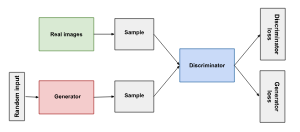

## Imports

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

Its always a good practice to check the current version of TensorFlow...

In [ ]:
print(tf.version.VERSION)

2.13.0


## Prepare Fashion-MNIST data
The first step is to get data ready for training.


### Loading

In [ ]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


There are 60,000 training gray scale images in Fashion-MNIST.

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
type(train_images)

numpy.ndarray

### Visualization

I always like to visualize the training data to get an idea of what the images look like.

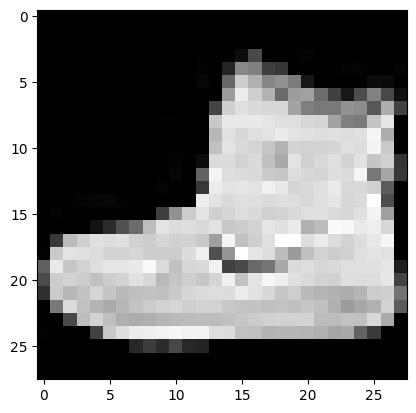

In [ ]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

### Preprocessing

In [ ]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5

(60000, 28, 28)
(60000, 28, 28, 1)


## The generator model

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 28x28x1.

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 100
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [ ]:
def build_generator():
    # create a Keras Sequential model
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
# build the generator model
generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       819328    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 128)       51

## The discriminator model

Define the discriminator model architecture with the Keras `Sequential` API

In [ ]:
def build_discriminator(width, height, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [ ]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

## Define `DCGAN` class: override `train_step`
Subclass `keras.Model` and override `train_step` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation.

**The discriminator loss** includes both the loss from the real images and the loss from the fake images.  
**The generator loss** is calculated with thefake images.


In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0)
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Use Keras `Callback` to monitor training

The nice thing about overriding `train_step` of `keras.Model` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to visually inspect the progress of the generator. You can also save the generator model at the end of the training which could potentially be used for inference later.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

## Train the DCGAN model

Compile the `dcgan` model, with the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy** loss functionas recommended by the paper. In future GAN tutorials, you will learn other loss functions for other GAN variants.

Putting together the `dcgan` model.

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

Compile the `dcgan` model.

In [ ]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Now we simply call `model.fit()` to traing the `dcgan` model!

Epoch 1/50
   5/1875 [..............................] - ETA: 52s - d_loss: 0.7207 - g_loss: 0.8053

1875/1875 [==============================] - ETA: 0s - d_loss: 0.2724 - g_loss: 1.4104

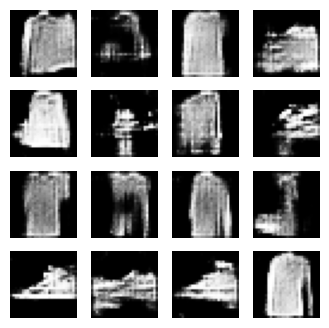

1875/1875 [==============================] - 49s 18ms/step - d_loss: 0.2724 - g_loss: 1.4104
Epoch 2/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6110 - g_loss: 0.9928

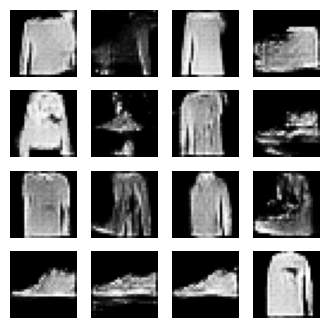

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6110 - g_loss: 0.9928
Epoch 3/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6359 - g_loss: 0.9127

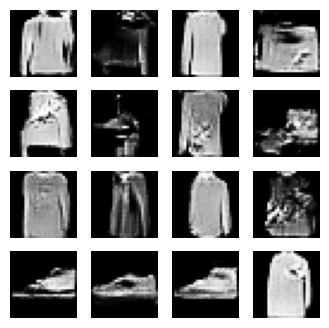

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6359 - g_loss: 0.9129
Epoch 4/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6540 - g_loss: 0.8960

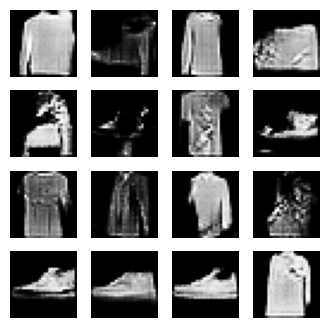

1875/1875 [==============================] - 35s 19ms/step - d_loss: 0.6540 - g_loss: 0.8960
Epoch 5/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6592 - g_loss: 0.8763

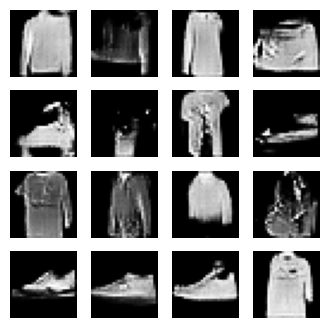

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6592 - g_loss: 0.8763
Epoch 6/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6621 - g_loss: 0.8460

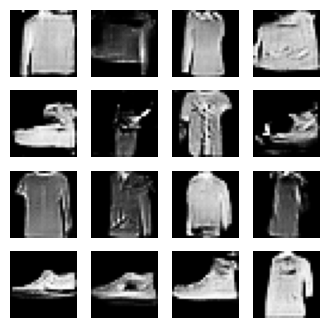

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6621 - g_loss: 0.8459
Epoch 7/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6649 - g_loss: 0.8361

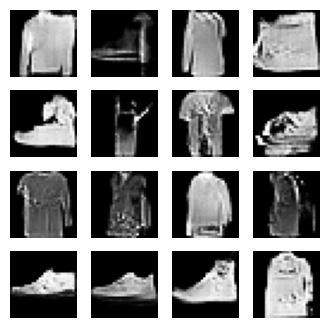

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6647 - g_loss: 0.8361
Epoch 8/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6657 - g_loss: 0.8307

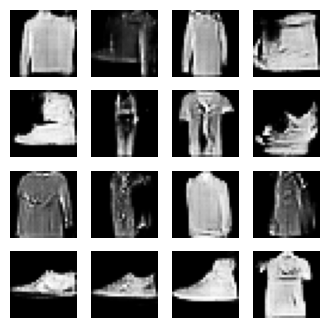

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6657 - g_loss: 0.8307
Epoch 9/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6636 - g_loss: 0.8351

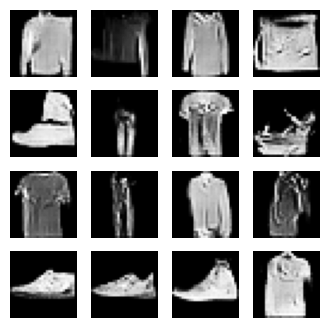

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6636 - g_loss: 0.8352
Epoch 10/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6674 - g_loss: 0.8333

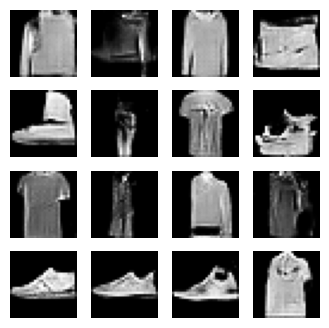

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6674 - g_loss: 0.8333
Epoch 11/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6652 - g_loss: 0.8268

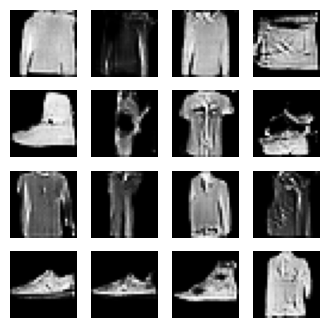

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6652 - g_loss: 0.8268
Epoch 12/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6657 - g_loss: 0.8245

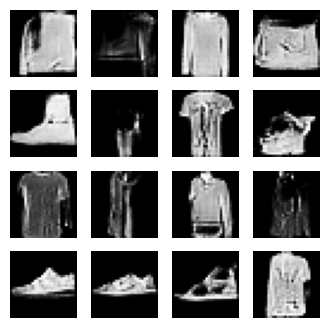

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6657 - g_loss: 0.8246
Epoch 13/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6669 - g_loss: 0.8293

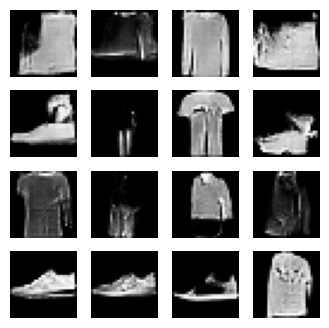

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6668 - g_loss: 0.8294
Epoch 14/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6672 - g_loss: 0.8228

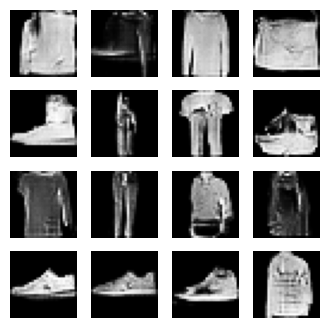

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6672 - g_loss: 0.8228
Epoch 15/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6682 - g_loss: 0.8251

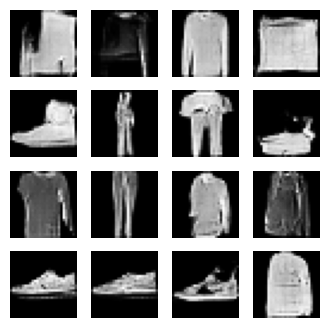

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6682 - g_loss: 0.8251
Epoch 16/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6677 - g_loss: 0.8175

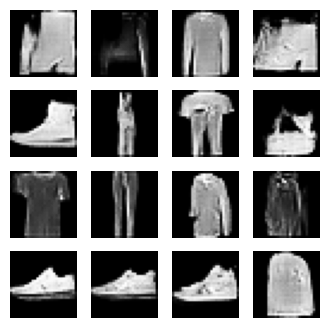

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6678 - g_loss: 0.8175
Epoch 17/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6684 - g_loss: 0.8146

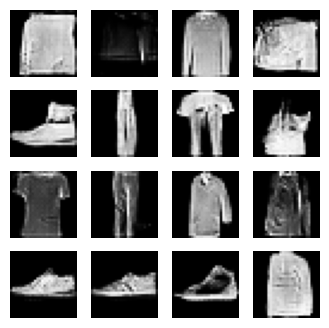

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6684 - g_loss: 0.8146
Epoch 18/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6670 - g_loss: 0.8202

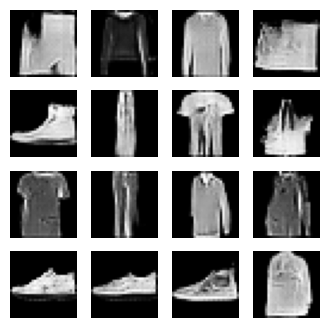

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6670 - g_loss: 0.8202
Epoch 19/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6687 - g_loss: 0.8182

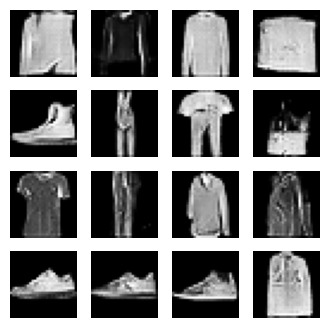

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6687 - g_loss: 0.8181
Epoch 20/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6679 - g_loss: 0.8157

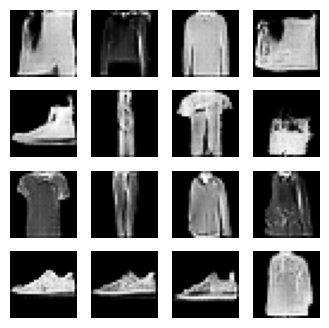

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6678 - g_loss: 0.8157
Epoch 21/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6687 - g_loss: 0.8143

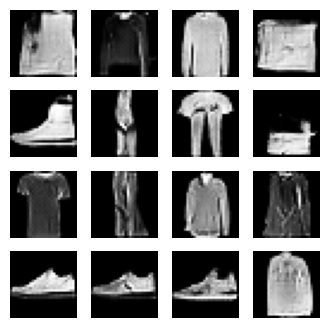

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6687 - g_loss: 0.8144
Epoch 22/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6678 - g_loss: 0.8162

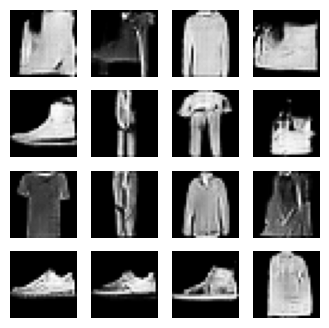

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6678 - g_loss: 0.8163
Epoch 23/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6684 - g_loss: 0.8109

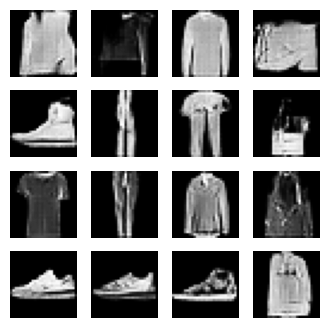

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6684 - g_loss: 0.8109
Epoch 24/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6678 - g_loss: 0.8101

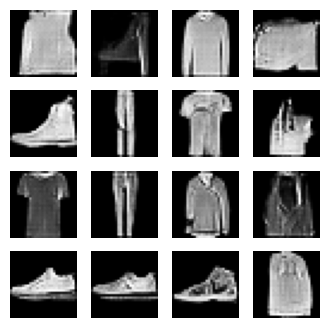

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6678 - g_loss: 0.8101
Epoch 25/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6658 - g_loss: 0.8134

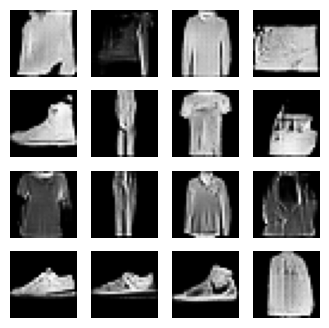

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6658 - g_loss: 0.8135
Epoch 26/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6660 - g_loss: 0.8126

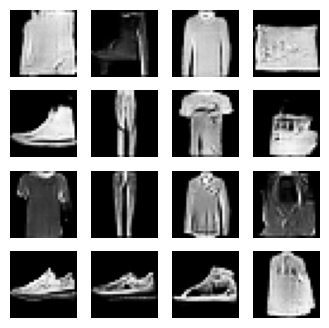

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6660 - g_loss: 0.8126
Epoch 27/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6660 - g_loss: 0.8152

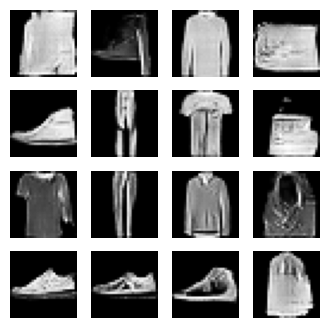

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6660 - g_loss: 0.8152
Epoch 28/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6677 - g_loss: 0.8164

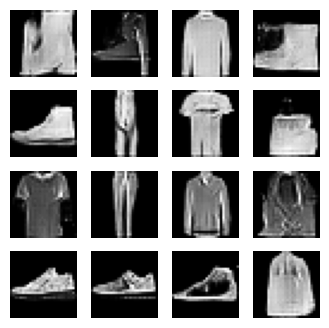

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6677 - g_loss: 0.8164
Epoch 29/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6666 - g_loss: 0.8149

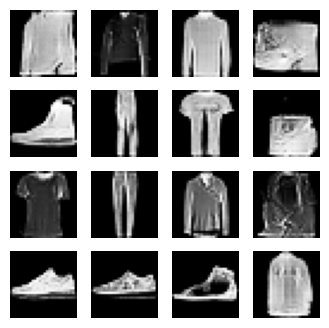

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6666 - g_loss: 0.8149
Epoch 30/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6658 - g_loss: 0.8185

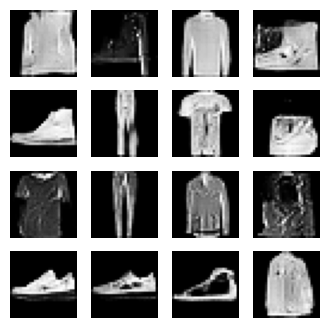

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6658 - g_loss: 0.8184
Epoch 31/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6659 - g_loss: 0.8180

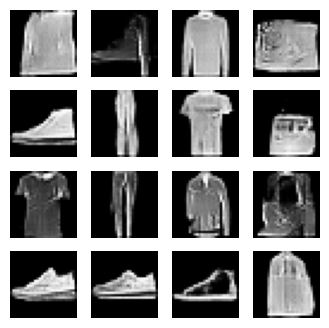

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6659 - g_loss: 0.8180
Epoch 32/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6649 - g_loss: 0.8126

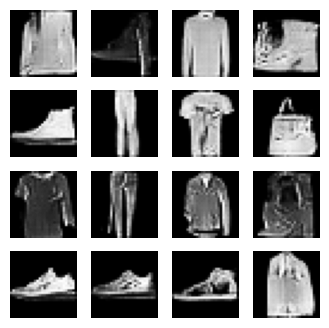

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6649 - g_loss: 0.8126
Epoch 33/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6651 - g_loss: 0.8158

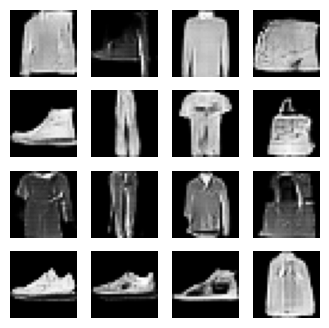

1875/1875 [==============================] - 37s 19ms/step - d_loss: 0.6651 - g_loss: 0.8158
Epoch 34/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6654 - g_loss: 0.8164

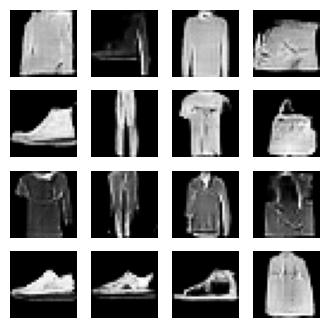

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6654 - g_loss: 0.8163
Epoch 35/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6626 - g_loss: 0.8148

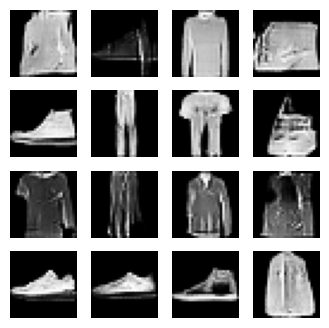

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6626 - g_loss: 0.8148
Epoch 36/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6632 - g_loss: 0.8138

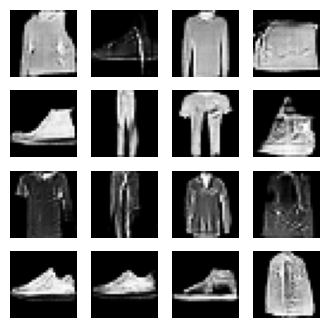

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6632 - g_loss: 0.8138
Epoch 37/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6655 - g_loss: 0.8136

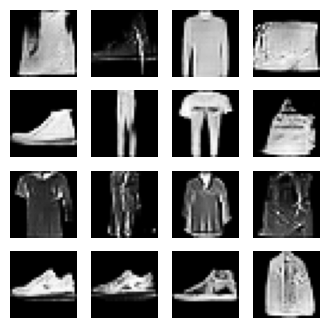

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6654 - g_loss: 0.8137
Epoch 38/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6646 - g_loss: 0.8121

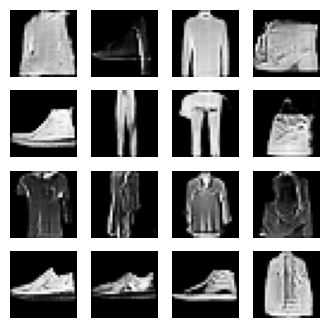

1875/1875 [==============================] - 37s 19ms/step - d_loss: 0.6646 - g_loss: 0.8122
Epoch 39/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6645 - g_loss: 0.8157

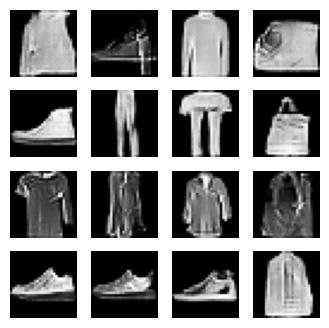

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6645 - g_loss: 0.8157
Epoch 40/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6647 - g_loss: 0.8156

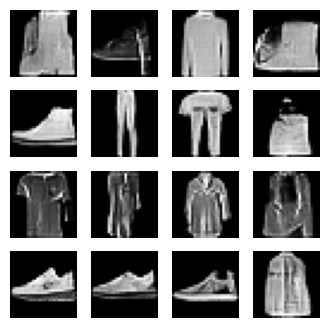

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6647 - g_loss: 0.8156
Epoch 41/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6647 - g_loss: 0.8122

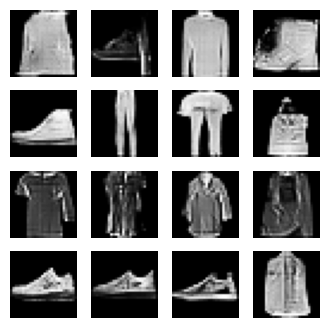

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6646 - g_loss: 0.8122
Epoch 42/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6664 - g_loss: 0.8147

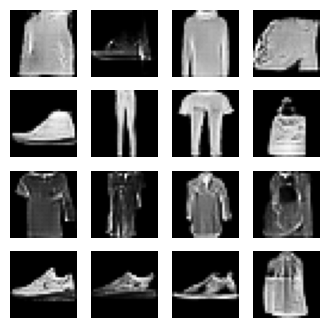

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6664 - g_loss: 0.8147
Epoch 43/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6644 - g_loss: 0.8102

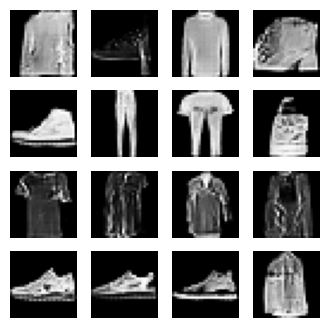

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6644 - g_loss: 0.8102
Epoch 44/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6619 - g_loss: 0.8090

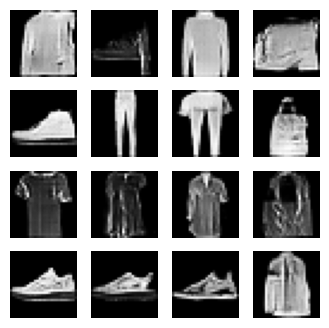

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6619 - g_loss: 0.8090
Epoch 45/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6635 - g_loss: 0.8093

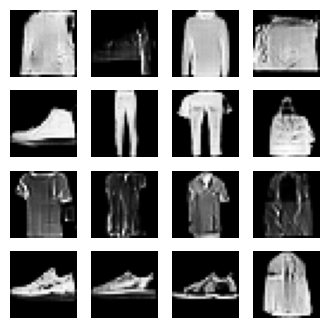

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6635 - g_loss: 0.8093
Epoch 46/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6652 - g_loss: 0.8096

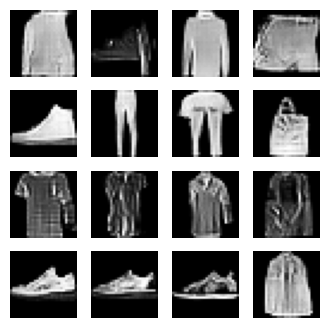

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6652 - g_loss: 0.8097
Epoch 47/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6634 - g_loss: 0.8076

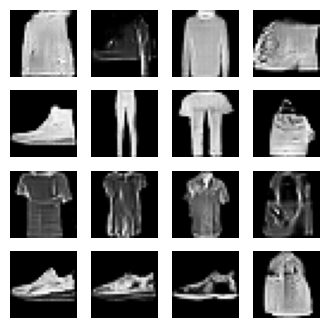

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6634 - g_loss: 0.8076
Epoch 48/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6632 - g_loss: 0.8058

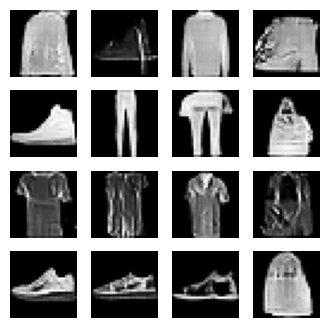

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6631 - g_loss: 0.8058
Epoch 49/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6637 - g_loss: 0.8128

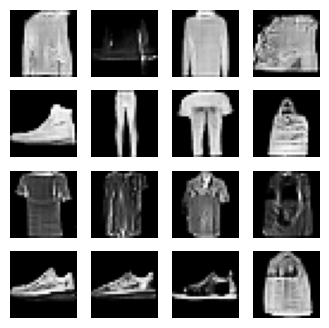

1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.6637 - g_loss: 0.8128
Epoch 50/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6636 - g_loss: 0.8126

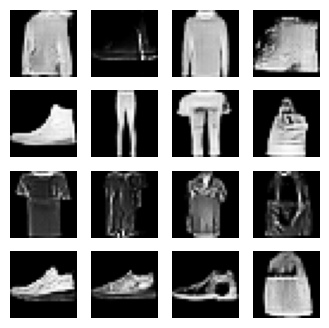

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6636 - g_loss: 0.8126


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])